# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report

# Copying and visualizing the DataFrame

In [2]:
df = pd.read_csv("train.csv")
df_copy = df.copy(deep=True)
df_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_copy.info()
print("\n")
display(df_copy["Survived"].mean().round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB




np.float64(0.38)

# Pre-processing

## Deleting unnecessary features

In [4]:
df_copy.drop(columns=["PassengerId", "Ticket", "Embarked"], inplace=True)
df_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN


## Creating a feature that sorts by Name Title

In [5]:
pat = " ([A-Za-z]+)\."
df_copy["NameTitle"] = df_copy["Name"].str.extract(pat, expand=True)
df_copy["NameTitle"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [6]:
df_copy.drop(columns=["Name"], inplace=True)
df_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NameTitle
0,0,3,male,22.0,1,0,7.2500,NaN,Mr
1,1,1,female,38.0,1,0,71.2833,C85,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,Miss
3,1,1,female,35.0,1,0,53.1000,C123,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,Mr


In [7]:
mapping_NameTitle = {
    "Lady": "Nobility",
    "Sir": "Nobility",
    "Don": "Nobility",
    "Countess": "Nobility",
    "Jonkheer": "Nobility",
    "Dona": "Nobility",
    "Capt": "Military",
    "Col": "Military",
    "Major": "Military",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs"
}
df_copy["NameTitle"] = df_copy["NameTitle"].replace(mapping_NameTitle)
df_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NameTitle
0,0,3,male,22.0,1,0,7.2500,NaN,Mr
1,1,1,female,38.0,1,0,71.2833,C85,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,Miss
3,1,1,female,35.0,1,0,53.1000,C123,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,Mr


In [8]:
df_copy["NameTitle"].value_counts()

NameTitle
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Nobility      5
Military      5
Name: count, dtype: int64

## Special Case: There is one female doctor. Therefore, I changed her NameTitle to Mrs.

In [9]:
df_copy[df_copy["NameTitle"] == "Dr"]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NameTitle
245,0,1,male,44.0,2,0,90.0000,C78,Dr
317,0,2,male,54.0,0,0,14.0000,NaN,Dr
398,0,2,male,23.0,0,0,10.5000,NaN,Dr
632,1,1,male,32.0,0,0,30.5000,B50,Dr
660,1,1,male,50.0,2,0,133.6500,NaN,Dr
766,0,1,male,NaN,0,0,39.6000,NaN,Dr
796,1,1,female,49.0,0,0,25.9292,D17,Dr


In [10]:
df_copy.loc[(df_copy["NameTitle"] == "Dr") & (df_copy["Sex"] == "female"), "NameTitle"] = "Mrs"

In [11]:
df_copy[df_copy["NameTitle"] == "Dr"]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NameTitle
245,0,1,male,44.0,2,0,90.00,C78,Dr
317,0,2,male,54.0,0,0,14.00,NaN,Dr
398,0,2,male,23.0,0,0,10.50,NaN,Dr
632,1,1,male,32.0,0,0,30.50,B50,Dr
660,1,1,male,50.0,2,0,133.65,NaN,Dr
766,0,1,male,NaN,0,0,39.60,NaN,Dr


## Interesting Case: All Rev died (Survived = 0)

In [12]:
df_copy[df_copy["NameTitle"] == "Rev"]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NameTitle
149,0,2,male,42.0,0,0,13.000,NaN,Rev
150,0,2,male,51.0,0,0,12.525,NaN,Rev
249,0,2,male,54.0,1,0,26.000,NaN,Rev
626,0,2,male,57.0,0,0,12.350,NaN,Rev
848,0,2,male,28.0,0,1,33.000,NaN,Rev
886,0,2,male,27.0,0,0,13.000,NaN,Rev


## Adding the average age of each NameTitle at their null ages

In [13]:
age_means = df_copy.groupby("NameTitle")["Age"].mean()
age_suggestions = df_copy["NameTitle"].map(age_means)
df_copy["Age"] = df_copy["Age"].fillna(age_suggestions)
df_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NameTitle
0,0,3,male,22.0,1,0,7.2500,NaN,Mr
1,1,1,female,38.0,1,0,71.2833,C85,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,Miss
3,1,1,female,35.0,1,0,53.1000,C123,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,Mr


## Analysing whether the presence of a cabin indicates survival

In [14]:
df_copy["Has_Cabin"] = df_copy["Cabin"].isna().astype(int)
df_copy["Has_Cabin"] = 1 - df_copy["Has_Cabin"] # Thus 1 = True | 0 = False
df_copy.drop(columns=["Cabin"], inplace=True)

In [15]:
df_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NameTitle,Has_Cabin
0,0,3,male,22.0,1,0,7.2500,Mr,0
1,1,1,female,38.0,1,0,71.2833,Mrs,1
2,1,3,female,26.0,0,0,7.9250,Miss,0
3,1,1,female,35.0,1,0,53.1000,Mrs,1
4,0,3,male,35.0,0,0,8.0500,Mr,0


<Axes: xlabel='Has_Cabin', ylabel='count'>

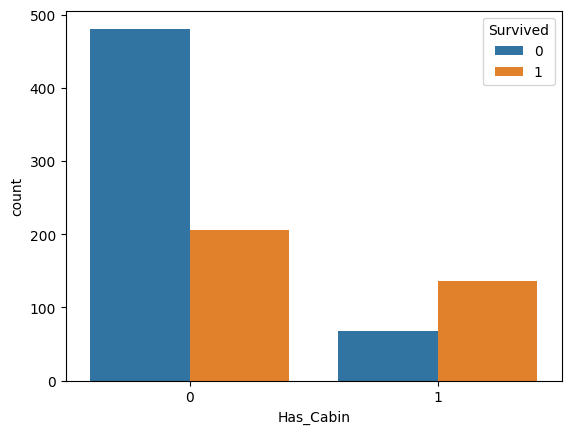

In [16]:
sns.countplot(df_copy, x="Has_Cabin", hue="Survived")

## The data confirms a strong correlation between cabin assignment and survival rates

## Analysing whether the Fare feature influences the survivor indicator

<Axes: xlabel='Fare'>

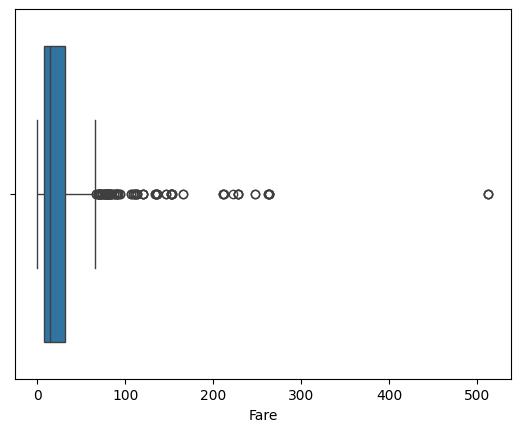

In [17]:
sns.boxplot(x=df_copy["Fare"])

## The bloxplot shows that most passengers paid lower fares, indicating they were from the middle or lower classes. Notably, the high-fare passengers appears as outliers on the right

<Axes: xlabel='Fare', ylabel='Survived'>

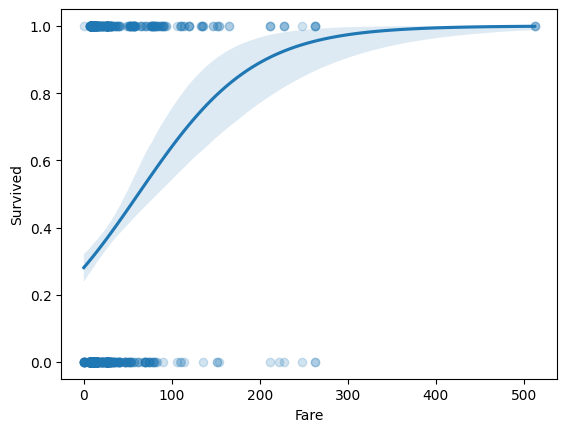

In [18]:
sns.regplot(df_copy, x="Fare", y="Survived", logistic=True, scatter_kws={"alpha":0.2})

## The graph confirms that fare directly influences the survival probability.

## The difference in survival rates between male and female gender

<Axes: xlabel='Sex', ylabel='count'>

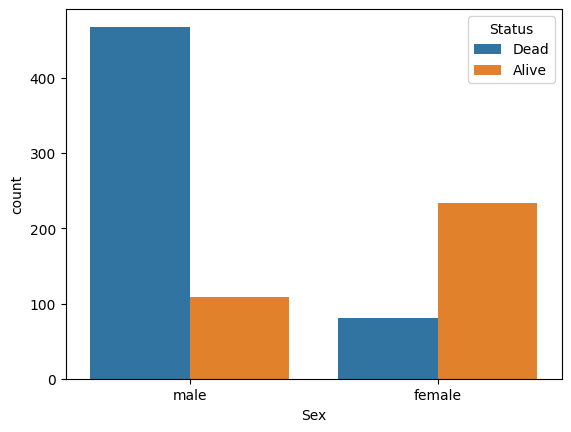

In [19]:
mapping = {0: "Dead", 1: "Alive"}
df_copy["Status"] = df_copy["Survived"].map(mapping)
sns.countplot(df_copy, x="Sex", hue="Status")

In [20]:
df_copy.drop(columns=["Status"], inplace=True)

## Creating a Family Size column that represent the sum of Siblings, Spouses and Parch, including the passenger in question

In [21]:
df_copy["FamilySize"] = df_copy["SibSp"] + df_copy["Parch"] + 1
df_copy.drop(columns=["SibSp", "Parch"],inplace=True)
df_copy.head()

,Survived,Pclass,Sex,Age,Fare,NameTitle,Has_Cabin,FamilySize
0,0,3,male,22.0,7.2500,Mr,0,2
1,1,1,female,38.0,71.2833,Mrs,1,2
2,1,3,female,26.0,7.9250,Miss,0,1
3,1,1,female,35.0,53.1000,Mrs,1,2
4,0,3,male,35.0,8.0500,Mr,0,1


# Encoding categorical and scaling numeric features

In [23]:
ct = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), ["NameTitle"]),
    ("ordinal", OrdinalEncoder(), ["Sex"]),
    ("scaler", StandardScaler(), ["Age", "Fare", "FamilySize"]),
    ("original", "passthrough", ["Pclass", "Has_Cabin"])
])
X_processed = ct.fit_transform(df_copy)
X_processed

array([[ 0.        ,  0.        ,  0.        , ...,  0.05915988,
         3.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.05915988,
         1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.56097483,
         3.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.29942929,
         3.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.56097483,
         1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.56097483,
         3.        ,  0.        ]], shape=(891, 14))

In [24]:
new_columns = ct.get_feature_names_out()
df_verification = pd.DataFrame(X_processed, columns=new_columns)
df_verification.head()

,onehot__NameTitle_Dr,onehot__NameTitle_Master,onehot__NameTitle_Military,onehot__NameTitle_Miss,onehot__NameTitle_Mr,onehot__NameTitle_Mrs,onehot__NameTitle_Nobility,onehot__NameTitle_Rev,ordinal__Sex,scaler__Age,scaler__Fare,scaler__FamilySize,original__Pclass,original__Has_Cabin
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.584635,-0.502445,0.059160,3.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.621390,0.786845,0.059160,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.283129,-0.488854,-0.560975,3.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.395260,0.420730,0.059160,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.395260,-0.486337,-0.560975,3.0,0.0


<Axes: >

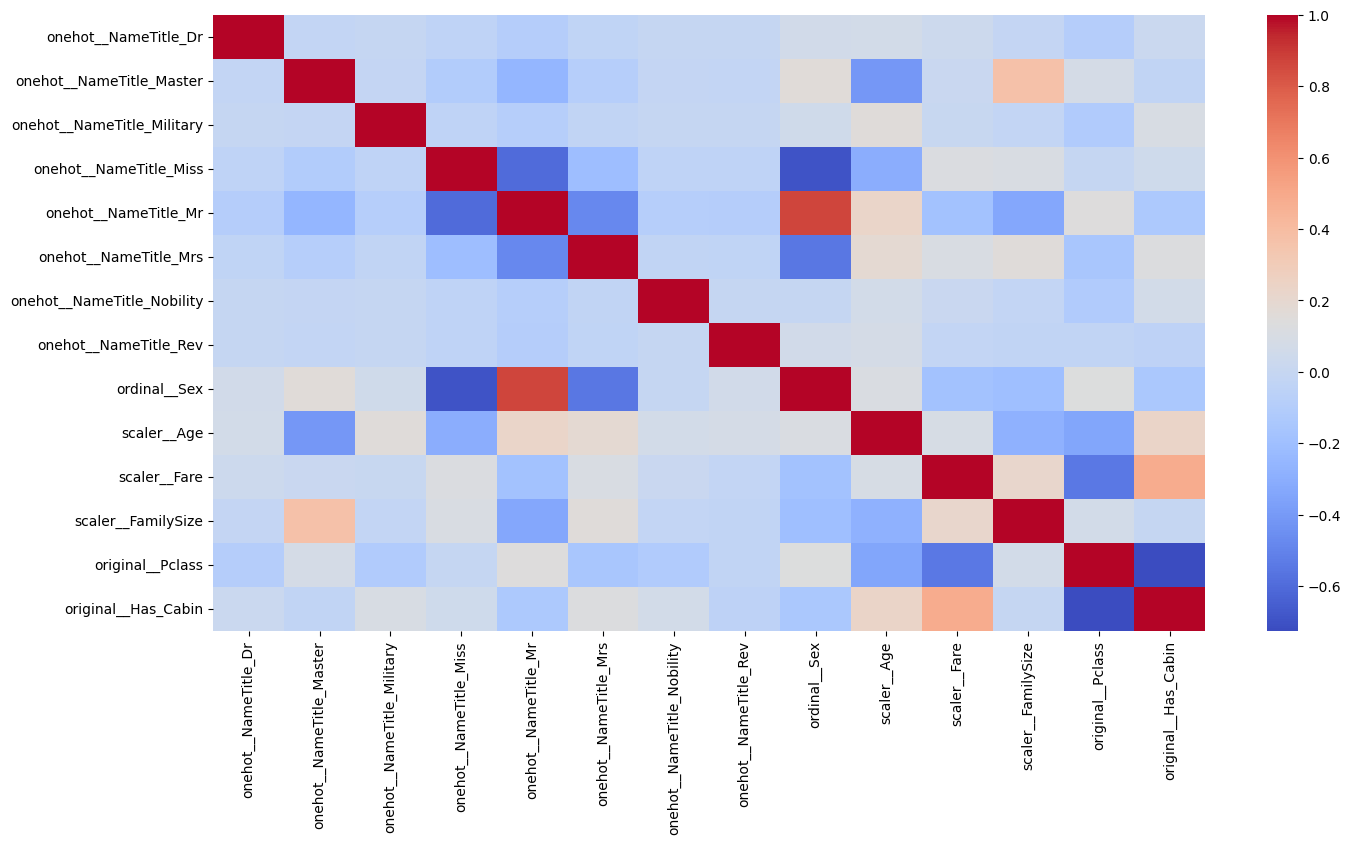

In [25]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_verification.corr(), annot=False, cmap="coolwarm")

# Model Training

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop(columns=["Survived"]), df_copy["Survived"],  random_state=41, test_size=0.2)

## Refining NameTitle based on Feature Importance

In [27]:
print(mapping_NameTitle)

{'Lady': 'Nobility', 'Sir': 'Nobility', 'Don': 'Nobility', 'Countess': 'Nobility', 'Jonkheer': 'Nobility', 'Dona': 'Nobility', 'Capt': 'Military', 'Col': 'Military', 'Major': 'Military', 'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}


In [28]:
mapping_NameTitle = {
    "Rev": "Mr", 
    "Dr": "Officer", "Col": "Officer", "Capt": "Officer", "Major": "Officer",
    "Jonkheer": "Prestige", "Don": "Prestige", "Sir": "Prestige", "Lady": "Prestige", "Countess": "Prestige"
}
df_copy["NameTitle"] = df_copy["NameTitle"].replace(mapping_NameTitle)


 Performance Evaluation: Logistic Regression 

Cross-Validation Score: 0.8118

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       105
           1       0.85      0.77      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



Coefficient Analysis: Examining feature weights and their impact on the Logistic Regression prediction.




,Attribute,Coefficient
1,onehot__NameTitle_Master,1.426029
5,onehot__NameTitle_Mrs,0.980031
13,original__Has_Cabin,0.446516
3,onehot__NameTitle_Miss,0.209794
10,scaler__Fare,0.165446
6,onehot__NameTitle_Nobility,-0.188886
0,onehot__NameTitle_Dr,-0.317373
2,onehot__NameTitle_Military,-0.367711
9,scaler__Age,-0.527045
7,onehot__NameTitle_Rev,-0.763104


<Figure size 1600x800 with 0 Axes>

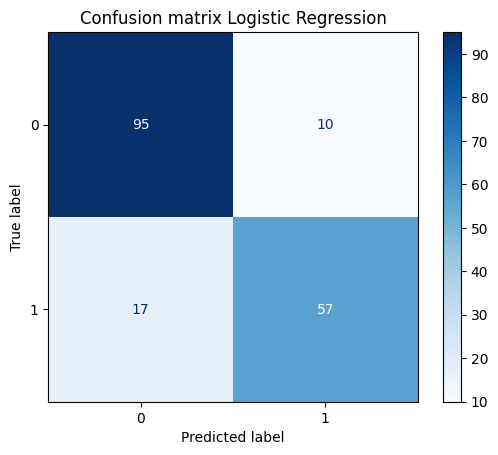


 Performance Evaluation: KNN 

Cross-Validation Score: 0.7978

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       105
           1       0.86      0.65      0.74        74

    accuracy                           0.81       179
   macro avg       0.82      0.79      0.79       179
weighted avg       0.82      0.81      0.80       179



<Figure size 1600x800 with 0 Axes>

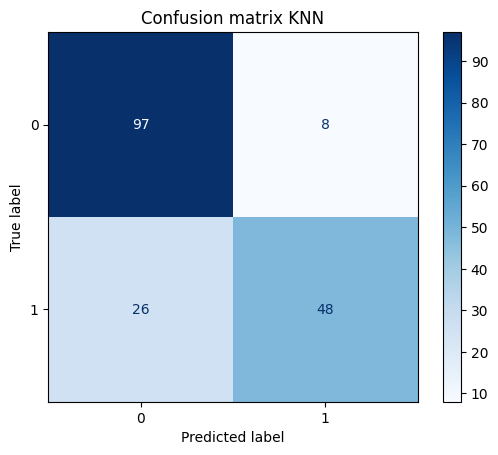


 Performance Evaluation: Random Forest 

Cross-Validation Score: 0.8062

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       105
           1       0.95      0.70      0.81        74

    accuracy                           0.86       179
   macro avg       0.88      0.84      0.85       179
weighted avg       0.87      0.86      0.86       179



Feature Importance Analysis: Identifying the most influential attributes for the Random Forest model.




,Attribute,Importance
10,scaler__Fare,0.280139
9,scaler__Age,0.233181
8,ordinal__Sex,0.105216
4,onehot__NameTitle_Mr,0.104859
11,scaler__FamilySize,0.082126
12,original__Pclass,0.077108
13,original__Has_Cabin,0.036504
3,onehot__NameTitle_Miss,0.032104
5,onehot__NameTitle_Mrs,0.029509
1,onehot__NameTitle_Master,0.011053


<Figure size 1600x800 with 0 Axes>

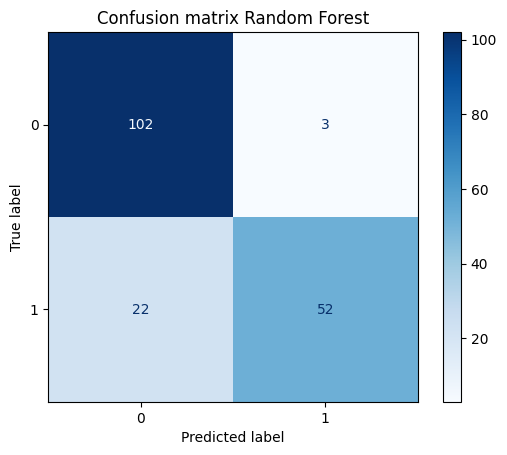

In [29]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

resultados = []

for name, model in models.items():
    temp_pipe = Pipeline([("preprocessor", ct), ("model", model)])

    print(f"\n{'='*50}")
    print(f" Performance Evaluation: {name} ")
    print(f"{'='*50}\n")

    scores = cross_val_score(temp_pipe, X_train, y_train, cv=5, n_jobs=-1)
    print(f"Cross-Validation Score: {scores.mean():.4f}")
    
    temp_pipe.fit(X_train, y_train)
    y_pred = temp_pipe.predict(X_test)
    
    plt.figure(figsize=(16, 8))
    ConfusionMatrixDisplay.from_estimator(temp_pipe, X_test, y_test, cmap="Blues")
    plt.title(f"Confusion matrix {name}")
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    feature_names = ct.get_feature_names_out()
    trained_model = temp_pipe.named_steps['model']
    
    if name == "Random Forest":
        print(f"\n{'='*50}")
        print("\nFeature Importance Analysis: Identifying the most influential attributes for the Random Forest model.")
        print(f"\n{'='*50}\n")
        importance = trained_model.feature_importances_
        df_importance = pd.DataFrame({
            "Attribute": feature_names, 
            "Importance": importance
        }).sort_values(by="Importance", ascending=False)
        display(df_importance)
        
    elif name == "Logistic Regression":
        print(f"\n{'='*50}")
        print("\nCoefficient Analysis: Examining feature weights and their impact on the Logistic Regression prediction.")
        print(f"\n{'='*50}\n")
        df_coef = pd.DataFrame({
            "Attribute": feature_names,
            "Coefficient": trained_model.coef_[0]
        }).sort_values(by="Coefficient", ascending=False)
        display(df_coef)
    
    plt.show()
    

    resultados.append({"Model": name, "Mean": scores.mean(), "Std Deviation": scores.std()})